In [89]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import zipfile
import os

In [90]:
base_dir = '../input/nyc-taxi-trip-duration'
train_dir = os.path.join(base_dir, 'train.zip')
test_dir = os.path.join(base_dir, 'test.zip')

with zipfile.ZipFile(train_dir, 'r') as z:
    z.extractall()

with zipfile.ZipFile(test_dir, 'r') as z:
    z.extractall()

In [91]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [92]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)

In [93]:
le = LabelEncoder()
le.fit(train['store_and_fwd_flag'])
train['store_and_fwd_flag'] = le.transform(train['store_and_fwd_flag'])
test['store_and_fwd_flag'] = le.transform(test['store_and_fwd_flag'])

In [94]:
train['month'] = train['pickup_datetime'].dt.month
train['day'] = train['pickup_datetime'].dt.day
train['weekday'] = train['pickup_datetime'].dt.weekday
train['hour'] = train['pickup_datetime'].dt.hour
train['minute'] = train['pickup_datetime'].dt.minute

In [95]:
test['month'] = test['pickup_datetime'].dt.month
test['day'] = test['pickup_datetime'].dt.day
test['weekday'] = test['pickup_datetime'].dt.weekday
test['hour'] = test['pickup_datetime'].dt.hour
test['minute'] = test['pickup_datetime'].dt.minute

In [96]:
train['dist_long'] = train['pickup_longitude'] - train['dropoff_longitude']
test['dist_long'] = test['pickup_longitude'] - test['dropoff_longitude']

train['dist_lat'] = train['pickup_latitude'] - train['dropoff_latitude']
test['dist_lat'] = test['pickup_latitude'] - test['dropoff_latitude']

In [97]:
train['dist'] = np.sqrt(np.square(train['dist_long'])) + np.square(train['dist_lat'])
test['dist'] = np.sqrt(np.square(test['dist_long'])) + np.square(test['dist_lat'])

In [98]:
train['pickup_longitude_bin'] = np.round(train['pickup_longitude'] , 2)
train['pickup_latitude_bin'] = np.round(train['pickup_latitude'], 2)
train['dropoff_longitude_bin'] = np.round(train['dropoff_longitude'], 2)
train['dropoff_latitude_bin'] = np.round(train['dropoff_latitude'], 2)

In [99]:
test['pickup_longitude_bin'] = np.round(test['pickup_longitude'] , 2)
test['pickup_latitude_bin'] = np.round(test['pickup_latitude'], 2)
test['dropoff_longitude_bin'] = np.round(test['dropoff_longitude'], 2)
test['dropoff_latitude_bin'] = np.round(test['dropoff_latitude'], 2)

In [100]:
a = pd.concat([train, test]).groupby(['pickup_longitude_bin', 'pickup_latitude_bin']).size().reset_index()
b = pd.concat([train, test]).groupby(['dropoff_longitude_bin', 'dropoff_latitude_bin']).size().reset_index()

In [101]:
train = pd.merge(train, a, on = ['pickup_longitude_bin', 'pickup_latitude_bin'], how = 'left')
test = pd.merge(test, a, on = ['pickup_longitude_bin', 'pickup_latitude_bin'], how = 'left')

train = pd.merge(train, b, on = ['dropoff_longitude_bin', 'dropoff_latitude_bin'], how = 'left')
test = pd.merge(test, b, on = ['dropoff_longitude_bin', 'dropoff_latitude_bin'], how = 'left')

In [102]:
train['speed'] = 100000*train['dist'] / train['trip_duration']

In [103]:
a = train[['speed', 'pickup_longitude_bin', 'pickup_latitude_bin']].groupby(['pickup_longitude_bin', 'pickup_latitude_bin']).mean().reset_index()
a = a.rename(columns = {'speed':'ave_speed'})
b = train[['speed', 'dropoff_longitude_bin', 'dropoff_latitude_bin']].groupby(['dropoff_longitude_bin', 'dropoff_latitude_bin']).mean().reset_index()
b = b.rename(columns = {'speed':'ave_speed'})

In [104]:
train = pd.merge(train, a, on = ['pickup_longitude_bin', 'pickup_latitude_bin'], how = 'left')
test = pd.merge(test, a, on = ['pickup_longitude_bin', 'pickup_latitude_bin'], how = 'left')

train = pd.merge(train, b, on = ['dropoff_longitude_bin', 'dropoff_latitude_bin'], how = 'left')
test = pd.merge(test, b, on = ['dropoff_longitude_bin', 'dropoff_latitude_bin'], how = 'left')

In [105]:
train = train.drop(['speed', 'pickup_longitude_bin', 'pickup_latitude_bin', 'dropoff_longitude_bin', 'dropoff_latitude_bin'], axis = 1)
test = test.drop(['pickup_longitude_bin', 'pickup_latitude_bin', 'dropoff_longitude_bin', 'dropoff_latitude_bin'], axis = 1)

In [106]:
weather = pd.read_csv('../input/knycmetars2016/KNYC_Metars.csv')

In [107]:
weather['Time'] = pd.to_datetime(weather['Time'])
weather['year'] = weather['Time'].dt.year
weather['month'] = weather['Time'].dt.month
weather['day'] = weather['Time'].dt.day
weather['hour'] = weather['Time'].dt.hour
weather = weather[weather['year'] == 2016]

In [108]:
weather.head()

,Time,Temp.,Windchill,Heat Index,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions,year,month,day,hour
22,2016-01-01 00:00:00,5.6,3.2,NaN,0.58,1018.8,-2.2,16.1,WNW,11.1,0.0,0.0,None,Overcast,2016,1,1,0
23,2016-01-01 01:00:00,5.6,4.0,NaN,0.53,1018.5,-3.3,16.1,Variable,7.4,0.0,0.0,None,Overcast,2016,1,1,1
24,2016-01-01 02:00:00,5.6,4.0,NaN,0.51,1017.9,-3.9,16.1,Variable,7.4,0.0,0.0,None,Overcast,2016,1,1,2
25,2016-01-01 03:00:00,5.0,3.9,NaN,0.53,1017.8,-3.9,16.1,Variable,5.6,0.0,0.0,None,Overcast,2016,1,1,3
26,2016-01-01 04:00:00,5.0,3.3,NaN,0.55,1017.7,-3.3,16.1,West,7.4,0.0,0.0,None,Overcast,2016,1,1,4


In [109]:
train = pd.merge(train, weather[['Temp.', 'month', 'day', 'hour']], on = ['month', 'day', 'hour'], how = 'left')
test = pd.merge(test, weather[['Temp.', 'month', 'day', 'hour']], on = ['month', 'day', 'hour'], how = 'left')

In [110]:
xtrain = train.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration'], axis = 1)
xtest = test.drop(['id', 'pickup_datetime'], axis=1)
ytrain = train['trip_duration']
id_train = train['id'].values
id_test = test['id'].values

In [111]:
#del (train, test)

In [113]:
nrounds = 200

In [116]:
xgb_model = xgb.XGBRegressor(learning_rate=0.1, max_depth=14,
    subsample=0.8, colsample_bytree= 0.7,
    colsample_bylevel=0.7, num_boost_round = nrounds)

In [117]:
xgb_model.fit(xtrain, np.log(ytrain+1))

[01:04:30] WARNING: ../src/learner.cc:573: 
Parameters: { "num_boost_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=14,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_boost_round=200,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.8, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

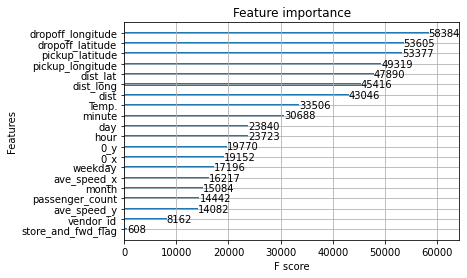

In [118]:
xgb.plot_importance(xgb_model)

In [125]:
predictions = xgb_model.predict(xtest)

In [126]:
predictions = np.exp(predictions) - 1

In [127]:
df = pd.DataFrame({'id':id_test, 'trip_duration':predictions})
df = df.set_index('id')

In [128]:
df.head()

,trip_duration
id,
id3004672,774.252747
id3505355,613.652283
id1217141,463.584656
id2150126,998.822266
id1598245,331.640778


In [ ]:
df.to_csv('xgb_fit.csv', index=True)